In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [69]:
# =======================
# 1. Cargar datos desde CSV/Excel
# =======================
# Colocar el archivo y la primera columna es fecha
df = pd.read_csv("Retornos2025_T2.csv", header=0)

# Convertimos a matriz de retornos excluyendo la primera columna (fechas)
retornos = df.iloc[:, 1:].copy()
n = retornos.shape[1]  # número de activos
nombres_activos = retornos.columns.tolist()

In [70]:
# =======================
# 2. Retornos y volatilidades anualizadas
# =======================
retornos_promedio = retornos.mean()
mu = retornos_promedio * 252                  # retornos anualizados
sigma = retornos.std() * np.sqrt(252)         # volatilidades anuales
Sigma = retornos.cov() * 252                  # matriz var-cov anualizada
correlaciones = retornos.corr()


In [71]:
# =======================
# 3. Portafolio específico
# =======================
w_especifico = np.array([0.37, 0.10, 0.23, 0.37, 0.40, 0.0, 0.0])
retorno_portafolio = np.dot(w_especifico, mu)
vol_portafolio = np.sqrt(w_especifico.T @ Sigma.values @ w_especifico)
var_portafolio = vol_portafolio**2

print("\n=== Portafolio específico ===")
print("Retorno anual (%):", round(retorno_portafolio, 2))
print("Volatilidad anual (%):", round(vol_portafolio, 2))
print("Varianza anual:", round(var_portafolio, 4))



=== Portafolio específico ===
Retorno anual (%): 0.14
Volatilidad anual (%): 0.22
Varianza anual: 0.0485


In [72]:
# =======================
# 4. Portafolio de mínima varianza global
# =======================
ones = np.ones(n)
inv_Sigma = np.linalg.inv(Sigma.values)
w_min_var = inv_Sigma @ ones / (ones @ inv_Sigma @ ones)
ret_min_var = np.dot(w_min_var, mu)
vol_min_var = np.sqrt(w_min_var.T @ Sigma.values @ w_min_var)

print("\n=== Portafolio mínima varianza ===")
print("Pesos:", np.round(w_min_var, 4))
print("Retorno anual (%):", round(ret_min_var, 2))
print("Volatilidad anual (%):", round(vol_min_var, 2))



=== Portafolio mínima varianza ===
Pesos: [ 0.3795 -0.0531  0.0025  0.304   0.0346  0.3434 -0.011 ]
Retorno anual (%): 0.08
Volatilidad anual (%): 0.12


In [73]:
# =======================
# 4b. Portafolio de tangencia (máxima Sharpe)
# =======================
def portafolio_tangencia(mu, Sigma, rf):
    n = len(mu)
    ones = np.ones(n)
    inv_Sigma = np.linalg.inv(Sigma.values)

    # Numerador: exceso de retorno ajustado por covarianzas
    numerador = inv_Sigma @ (mu.values - rf * ones)
    # Denominador: normalización
    denominador = ones @ numerador

    # Pesos del portafolio tangencia
    w_t = numerador / denominador
    return w_t

rf = 0.08  # tasa libre de riesgo
w_tan = portafolio_tangencia(mu, Sigma, rf)
ret_tan = np.dot(w_tan, mu)
vol_tan = np.sqrt(w_tan.T @ Sigma.values @ w_tan)

print("\n=== Portafolio tangencia ===")
print("Pesos:", np.round(w_tan, 4))
print("Retorno anual (%):", round(ret_tan, 4))
print("Volatilidad anual (%):", round(vol_tan, 4))


=== Portafolio tangencia ===
Pesos: [-18.2901  19.2362   5.0514 -14.6386   0.5217   3.8249   5.2946]
Retorno anual (%): 6.58
Volatilidad anual (%): 5.4123


In [74]:
# =======================
# 5. Frontera eficiente analítica
# =======================
A = ones @ inv_Sigma @ ones
B = ones @ inv_Sigma @ mu
C = mu.values @ inv_Sigma @ mu.values
D = A*C - B**2

retorno_obj = np.linspace(-1, 1, 200)  # retornos objetivos
vols_frontera = []

for R_p in retorno_obj:
    lambda1 = (C - B*R_p) / D
    lambda2 = (A*R_p - B) / D
    w = inv_Sigma @ (lambda1*ones + lambda2*mu.values)
    vols_frontera.append(np.sqrt(w.T @ Sigma.values @ w))



In [75]:
# =======================
# 6. Métricas de riesgo y desempeño
# =======================
activo_ref = 0
beta_i = np.array([np.cov(retornos.iloc[:, i], retornos.iloc[:, activo_ref])[0, 1] /
                   np.var(retornos.iloc[:, activo_ref]) for i in range(n)])
beta_portafolio = np.dot(w_especifico, beta_i)

Sharpe = (retorno_portafolio - rf) / vol_portafolio
Traynor = (retorno_portafolio - rf) / beta_portafolio
CAPM = rf + beta_portafolio * (retorno_portafolio - rf)
div_ratio = vol_portafolio / sigma[activo_ref]

print("\n=== Métricas de riesgo y desempeño ===")
print("Beta portafolio:", round(beta_portafolio, 4))
print("Sharpe ratio:", round(Sharpe, 4))
print("Traynor ratio:", round(Traynor, 4))
print("CAPM (retorno esperado):", round(CAPM, 4))
print("Ratio de diversificación:", round(div_ratio, 4))




=== Métricas de riesgo y desempeño ===
Beta portafolio: 0.9353
Sharpe ratio: 0.2908
Traynor ratio: 0.0685
CAPM (retorno esperado): 0.1399
Ratio de diversificación: 1.2805


C:\Users\dell\AppData\Local\Temp\ipykernel_26960\3789420659.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  div_ratio = vol_portafolio / sigma[activo_ref]


In [76]:
# =======================
# 7. Función de utilidad
# =======================
A_util = 10
s0 = vol_portafolio
m0 = retorno_portafolio
U0 = m0 - 0.5*A_util*s0**2

s = np.linspace(0, 1, 200)
utilidad = U0 + 0.5*A_util*s**2


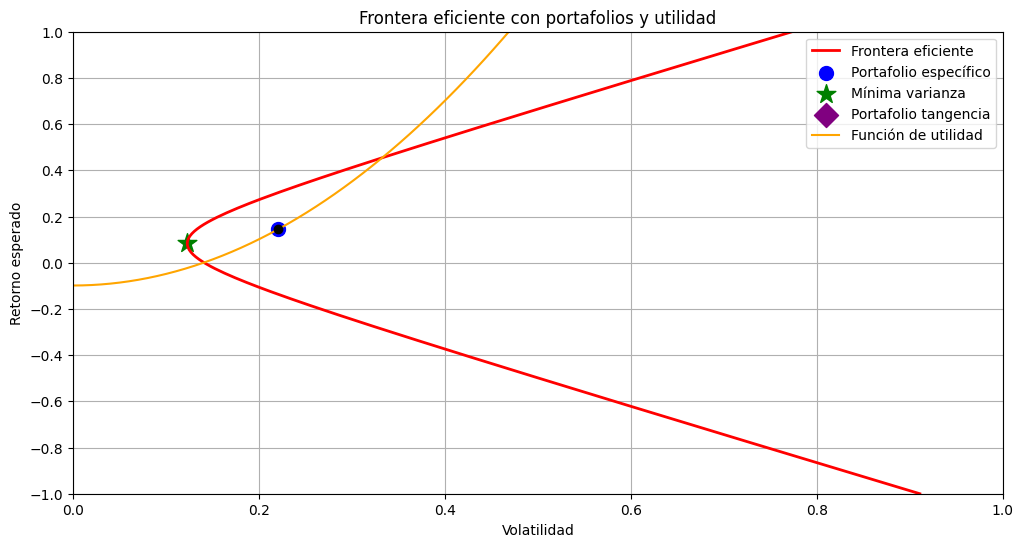

In [77]:
# =======================
# 8. Gráficas
# =======================
plt.figure(figsize=(12, 6))
plt.plot(vols_frontera, retorno_obj, 'r-', lw=2, label='Frontera eficiente')
plt.scatter(vol_portafolio, retorno_portafolio, c='blue', marker='o', s=100, label='Portafolio específico')
plt.scatter(vol_min_var, ret_min_var, c='green', marker='*', s=200, label='Mínima varianza')
plt.scatter(vol_tan, ret_tan, c='purple', marker='D', s=150, label='Portafolio tangencia')
plt.plot(s, utilidad, color='orange', label='Función de utilidad')
plt.scatter(s0, m0, color='black', zorder=5)

plt.xlabel('Volatilidad')
plt.ylabel('Retorno esperado')
plt.title('Frontera eficiente con portafolios y utilidad')

# Ejes y ticks
plt.xlim(0.0, 1.0)
plt.xticks(np.arange(0.0, 1.1, 0.2))
plt.ylim(-1.0, 1.0)
plt.yticks(np.arange(-1.0, 1.1, 0.2))

plt.legend()
plt.grid(True)
plt.show()
